In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, Exponentiation,RationalQuadratic, WhiteKernel
import random

/opt/miniconda3/envs/env_gal/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def generate_fake_data(xmin, xmax, n_samples=10, polynomial_degree=2, noise_level=1):
    x = [random.uniform(xmin, xmax) for _ in range(n_samples)]
    # Generate random noise of the same length as x
    noise = np.random.normal(scale=noise_level, size=n_samples)
    # Generate the y values according to a polynomial equation with some added noise
    y = np.polyval(np.random.randn(polynomial_degree + 1), x) + noise
    y = np.abs(y) # force y to be positive
    return np.array(x), np.array(y)

In [23]:
x,y = generate_fake_data(0, 10, 10, polynomial_degree=3, noise_level=5)

### Step 1: GP Fit

In [24]:
def GPR(X, Y, kernel= None):
    """
    Fit GP to demand
    run once per product

    :param X: X values with shape (-1, 1)
    :param Y: Y values with shape (-1, 1)
    :param kernel: kernel for the GP
    :return: GPR model
    """

    kernel = kernel
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gaussian_process.fit(X, Y)
    return gaussian_process

model = GPR(x.reshape(-1,1),y.reshape(-1,1), kernel = 1 * RationalQuadratic(alpha= 10, length_scale=1000) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e2)))
print(model)

GaussianProcessRegressor(kernel=1**2 * RationalQuadratic(alpha=10, length_scale=1e+03) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)


### Test Step 1

In [25]:
### Plot model to check
Xplot = np.linspace(-0.1, 10.1, 100)
f_mean, f_var = model.predict(Xplot.reshape(-1,1), return_std=True)

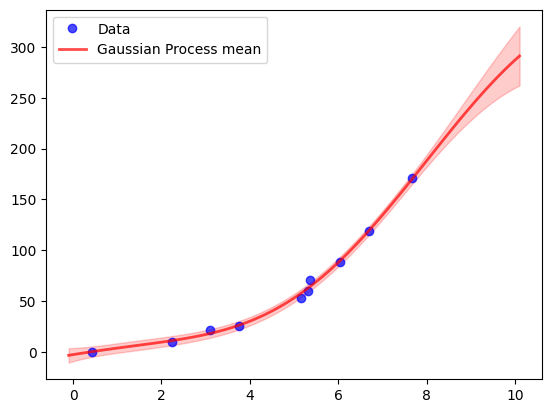

In [26]:
plt.plot(x, y, 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, f_mean, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, f_mean - f_var, f_mean + f_var, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend(); plt.show();

### Step 2 : Sample demand from GP
We use 2 products here to make things simpler

In [27]:
%%capture
### kernel
kernel = 1 * RationalQuadratic(alpha= 10, length_scale=100) +  WhiteKernel(noise_level=100, noise_level_bounds=(1e-5, 1e2))
### generate datasets for both products
Ds = [generate_fake_data(0, 10, n_samples=10, polynomial_degree=3, noise_level=4) for _ in range(2)]
### generate GPs for both products
GPs = [GPR(Ds[i][0].reshape(-1,1), Ds[i][1].reshape(-1,1), kernel = kernel) for i in range(2)]

In [28]:
### Plot model to check
Xplot = np.linspace(-0.1, 10.1, 100)
mean0, std0 = GPs[0].predict(Xplot.reshape(-1,1), return_std=True)
mean1, std1 = GPs[1].predict(Xplot.reshape(-1,1), return_std=True)

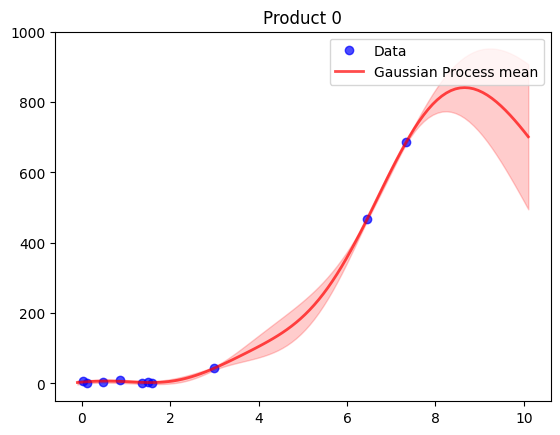

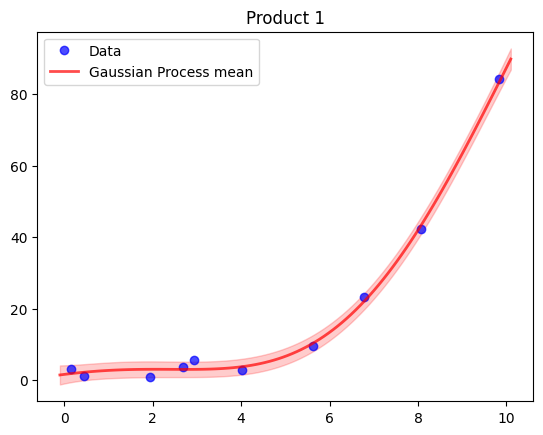

In [29]:
plt.figure()
plt.title('Product 0')
plt.plot(Ds[0][0], Ds[0][1], 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, mean0, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, mean0 - std0, mean0 + std0, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend()
plt.show()

plt.figure()
plt.title('Product 1')
plt.plot(Ds[1][0], Ds[1][1], 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, mean1, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, mean1 - std1, mean1 + std1, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend()
plt.show()

#### Sample for each price vector

In [30]:
### assume we only offer prices 1, 5, 7 --> get all possible price combinations
import itertools

def get_unique_permutations(lst, length):
    """
    Returns a list of all possible unique permutations of a given length of elements
    in a given list.
    """
    permutations = list(itertools.permutations(lst, length))
    unique_permutations = list(set(permutations))
    result = [list(x) for x in unique_permutations]
    same_val = [result.append([x]*2) for x in lst]
    return result

price_vectors = get_unique_permutations([1, 5, 8], length=2)
print(price_vectors)

[[5, 8], [8, 1], [1, 5], [1, 8], [5, 1], [8, 5], [1, 1], [5, 5], [8, 8]]


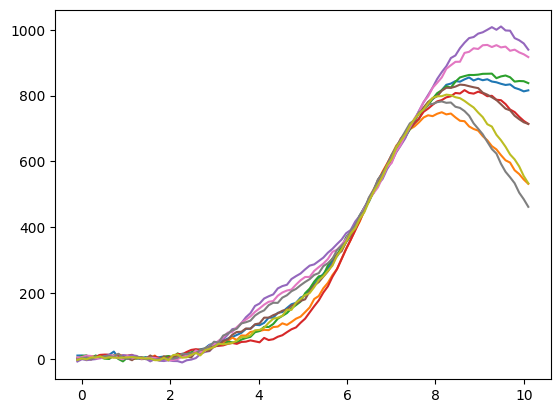

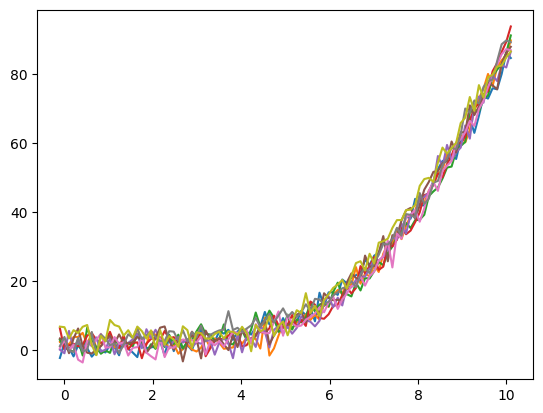

In [31]:
evaluated_y = []
for prod in range(2):
    # Generate samples from posterior distribution. One for each price vector
    y_hat_samples = GPs[prod].sample_y(Xplot.reshape(-1,1), n_samples=len(price_vectors), random_state=None) # no fixed behaviour!
    plt.plot(Xplot, y_hat_samples)
    # for each price vector evaluate demand using the correct GP sample. i.e for 0th element of each price vector, evaluate the GP[0] sample
    # for the 1st element of each price vector, evaluate GP[1] and so on
    evaluated_y.append([np.interp(price_vectors[i][prod], Xplot, y_hat_samples[:,i]) for i in range(len(price_vectors))])
    plt.show()
# combine indexes together to get back to price pairs [price_0, price_1]
evaluations = [list(i) for i in list(zip(*evaluated_y))]

In [32]:
evaluations, price_vectors

([[189.52609290243927, 42.75672458031142],
  [742.0730186810747, 3.689730641690965],
  [1.021714312326237, 8.430844999569784],
  [10.345919542598761, 38.889261188260114],
  [266.0507750754507, 2.4553276346480875],
  [795.7464630093178, 7.7261266812571545],
  [5.761284869431849, 0.873281016196037],
  [229.09723838761246, 10.901796212772535],
  [796.0417296175586, 45.52043823052595]],
 [[5, 8], [8, 1], [1, 5], [1, 8], [5, 1], [8, 5], [1, 1], [5, 5], [8, 8]])

### Step 3: Solve Linear Program
https://realpython.com/linear-programming-python/

In [33]:
from scipy.optimize import linprog

In [55]:
# define some max quantity of each product
max_inventory = [1000000, 1000000] # per product (unconstrained)
a = [[1,1] for _ in range(len(price_vectors))] # every time a sale happens we lose 1 product

# first get the coefficients for the linear program
result_for_lp = []
subject_to = []
for k in range(len(price_vectors)): # price vectors
    sub_k_result = []
    sub_subject_to = []
    for i in range(2): # products
        sub_k_result.append(price_vectors[k][i] * evaluations[k][i])
        sub_subject_to.append(a[k][i] * evaluations[k][i])
    subject_to.append(np.sum(sub_subject_to))
    result_for_lp.append(np.sum(sub_k_result))

subject_coeffs = [subject_to]*2 # one is needed per product as cj is different per product (potentially)

# xk inequality (sum of x <= 1)
xk_ineq = list(np.full(len(price_vectors),1))

# combine to make LHS inequalities
subject_coeffs.append(xk_ineq)

lhs_ineq = subject_coeffs # rename to be more clear
# Define RHS of the inequalities
max_inventory.append(1)

rhs_ineq = max_inventory

assert len(rhs_ineq) == len(lhs_ineq)
# xk >= 0 definition
bnd = [(0, float("inf")) for _ in range(len(price_vectors))]

# objective 
result_for_lp = [x*-1 for x in result_for_lp] # maximise!!!

# print(lhs_ineq, "\n")
# print(rhs_ineq)
# print(bnd)
# print(result_for_lp)

opt = linprog(c=result_for_lp, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd, method="revised simplex")

In [56]:
opt

     con: array([], dtype=float64)
     fun: -6732.497342784677
 message: 'Optimization terminated successfully.'
     nit: 1
   slack: array([999158.43783215, 999158.43783215,      0.        ])
  status: 0
 success: True
       x: array([0., 0., 0., 0., 0., 0., 0., 0., 1.])

### Random choice from x

In [57]:
choose_price_index = np.argwhere(opt['x'] == np.random.choice(opt['x'], p=opt['x']))[0][0]

In [58]:
price_vectors[choose_price_index]

[8, 8]

In [59]:
price_vectors

[[5, 8], [8, 1], [1, 5], [1, 8], [5, 1], [8, 5], [1, 1], [5, 5], [8, 8]]